<a href="https://colab.research.google.com/github/Margarita89/CityQuest/blob/master/quest_logic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transitions
!sudo apt-get install graphviz  # Ubuntu and Debian
!pip install graphviz pygraphviz # install graphviz and/or pygraphviz manually...
!pip install transitions[diagrams]  # ... or install transitions with 'diagrams' extras which currently depends on pygraphviz

In [83]:
#from transitions import Machine
from transitions.extensions import GraphMachine as Machine
import random
from enum import Enum, auto

In [100]:
map_state_to_sentence = {
    'select' : 'Sorry, wrong asnwer. Please, choose from 3 following options..',
    'no_more_hints' : 'Sorry, there are no more hints..'
}

map_question_to_hints_amount = {
    1 : 2,
    2 : 2
}

class QuestionEntities(Enum):
  question = auto()
  answer = auto()
  hints = auto()


map_question_num_to_data = {
    1 : {
          QuestionEntities.question: 'When its precursor, a menagerie, was founded?', 
          QuestionEntities.answer: '1864',
          QuestionEntities.hints: ['hint_1_1', 'hint_1_2']},
    2 : {
          QuestionEntities.question: 'Four thousand dollars towards the funding of the statue was raised at'
          ' a benefit of which performance?',
          QuestionEntities.answer: 'Julius Caesar',
          QuestionEntities.hints: ['hint_2_1', 'hint_2_2']}
}

class UserDecisions(Enum):
  hint = 'hint'
  returning = 'return'
  skip = 'skip'


class Quiz(object):

  # Define states
  states = ['question_1', 'select', '_analyze_answer', '_user_decision', 'final']

  def __init__(self):

    self.additional_message = ''
    self.user_hint_counter = 0
    self.current_question_num = 1
    self.total_questions = len(map_question_num_to_data)

    # Initialize the state machine
    self.machine = Machine(model=self, states=Quiz.states, initial='question_1')

    # When user answers move from question 1 to analyzing answer
    self.machine.add_transition(trigger='user_answers', source='question_1', dest='_analyze_answer',
                                after = 'get_user_answer')

    # If answer is correct move from question 1 to question 2
    self.machine.add_transition(trigger='go_to_next_question', source='_analyze_answer', dest='question_1')

    # If answer is incorrect move from question 1 to state 'select' 
    self.machine.add_transition(trigger='incorrect_answer', source='_analyze_answer', dest='select')

    # When user decides where to move from analyzing answer 
    self.machine.add_transition(trigger='user_decides', source='select', dest='_user_decision',
                                after = 'get_user_decision')

    # Return from state 'select' back to question 1
    self.machine.add_transition(trigger='returning', source='_user_decision', dest='question_1')

    # Skip this question from state 'select' to question 2
    self.machine.add_transition(trigger='skip', source='_user_decision', dest='question_1')

    # Choose hint and move from state 'select' back to question 1 with a hint
    self.machine.add_transition(
        trigger='hint', source='_user_decision', dest='question_1')
    
    # Move to state 'final' if there are no more questions
    self.machine.add_transition(
        trigger='move_to_final', source='_analyze_answer', dest='final')

  def get_user_answer(self, user_answer):
    self.additional_message = ''
    correct_answer = map_question_num_to_data[self.current_question_num][QuestionEntities.answer]
    if user_answer == correct_answer:
      self.move_to_next_question()
    else:
      self.incorrect_answer()

  def get_user_decision(self, user_decision):
    if user_decision == UserDecisions.hint.value:
      hints_array = map_question_num_to_data[self.current_question_num][QuestionEntities.hints]
      hints_amount = len(hints_array)
      if self.user_hint_counter < hints_amount:
        self.additional_message = hints_array[self.user_hint_counter]  
        self.user_hint_counter += 1
      else:
        self.additional_message = map_state_to_sentence['no_more_hints']
        
      self.hint()
    elif user_decision == UserDecisions.skip.value:
      self.skip()
    elif user_decision == UserDecisions.returning.value:
      self.returning()

  def get_state_message(self):
    if self.state == 'question_1':
      message = self.additional_message
      if message:
         message += '\n' 
      message += map_question_num_to_sentence[self.current_question_num]
      return message
    if self.state == 'select':
      return map_state_to_sentence[self.state]
  
  def move_to_next_question(self):
    if self.current_question_num < self.total_questions :
      self.current_question_num += 1
      self.user_hint_counter = 0
      self.go_to_next_question()
    else:
      self.move_to_final()

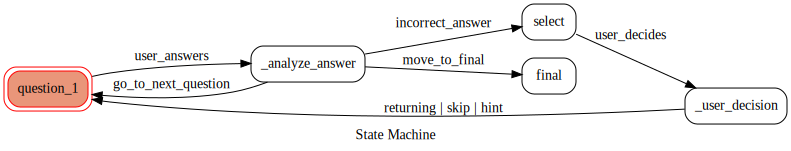

In [101]:
quiz = Quiz()
quiz.get_graph() #.draw('my_state_diagram.png', prog='dot')


In [113]:
user_answer = 'Julius Caesar'
print(f' State {quiz.state}')
print(quiz.get_state_message())
print(quiz.user_answers(user_answer=user_answer))
print(f' State {quiz.state}')

 State question_1
hint_2_2
Four thousand dollars towards the funding of the statue was raised at a benefit of which performance?
True
 State final


In [114]:
quiz.get_state_message()

In [111]:
user_decision = UserDecisions.hint.value
quiz.user_decides(user_decision=user_decision)

True

In [112]:
print(quiz.get_state_message())
print(f' State {quiz.state}')

hint_2_2
Four thousand dollars towards the funding of the statue was raised at a benefit of which performance?
 State question_1


In [ ]:
class Matter(object):
    def __init__(self): self.set_environment()
    def set_environment(self, temp=0, pressure=101.325):
        self.temp = temp
        self.pressure = pressure
    def print_temperature(self): print("Current temperature is %d degrees celsius." % self.temp)
    def print_pressure(self): print("Current pressure is %.2f kPa." % self.pressure)

lump = Matter()
machine = Machine(lump, ['solid', 'liquid'], initial='solid')
machine.add_transition('melt', 'solid', 'liquid', before='set_environment')

lump.melt(45)  # positional arg;
# equivalent to lump.trigger('melt', 45)
lump.print_temperature()
>>> 'Current temperature is 45 degrees celsius.'

machine.set_state('solid')  # reset state so we can melt again
lump.melt(pressure=300.23)  # keyword args also work
lump.print_pressure()
>>> 'Current pressure is 300.23 kPa.'